# Figure 1
Potential Density Difference (1500m to surface) for the 3 models. 500 year mean of the control simulations shown. 
Contours show areas in which September MLD is deeper than 2000m at least once during the 500yrs (for ESM2G & CM4).
For CM2Mc, Contours of Std Dev of MLD>200m on top.

MLD defined based on the Boyer-Montegut criteria of Rz – Ro <0.03.

Models are: 3$^{\circ}$ CM2MC, 1$^{\circ}$ ESM2G, 1$^{\circ}$ CM4. 

Contour with black line the Convection location …. Annually-averaged fields shown for the CM2Mc model.

In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy

## Calculate potential density & MLD from raw data (temperature, sanility)

In [3]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

In [4]:
# functions for fetching cmip6 data from google cloud
def rename_coords(ds):
    ds = ds.copy()
    """Rename all depth dim to `lev`"""
    if "olevel" in ds.coords:
        ds = ds.rename({"olevel": "lev"})
    if "lev_partial" in ds.coords:
        ds = ds.rename({"lev_partial": "lev"})
    """Rename all latitude, longitude dim to `lat`,`lon`"""
    if 'latitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    return ds

def get_dataset(col, var, freq, expe, model, grid):
    dataset = col.search(variable_id = var, table_id = freq, experiment_id = expe, 
                         source_id = model, grid_label = grid).to_dataset_dict(
        zarr_kwargs= {'consolidated': True, 'decode_times':True}, preprocess = rename_coords)
    dataset = dataset[list(dataset)[0]].squeeze('member_id').reset_coords('member_id', drop = True)
    return dataset

In [3]:
# functions for calculating potential density (dens0)
def sel_time(ds, start_year, end_year, month = None):
    ds = ds.isel(time = slice((start_year-1)*12, end_year*12))
    if month:
        ds = list(ds.groupby("time.month"))[month-1][-1]
    return ds

def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)
    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

def func_dens0(dataset, start_year, end_year, month_no = 9):
    da_t = sel_time(dataset.thetao, start_year, end_year, month = month_no)
    da_s = sel_time(dataset.so, start_year, end_year, month = month_no)
    da_dens = dens0(da_s, da_t)
    return da_dens

In [6]:
# CM4 data (monthly, using september data for calculation)
model_name = 'GFDL-CM4' 
experiment = 'piControl'
frequency = 'Omon'
variables = ['so', 'thetao']

ds_CM4 = get_dataset(col, variables, frequency, experiment, model_name, 'gr')
sigma0_cm4 = func_dens0(ds_CM4, 1, 500)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
# CM2Mc (annual)
ds_cm2mc = xr.open_mfdataset('/data/shared/marinov/data/model/CM2Mc/spinup_run/*')
ds_cm2mc = ds_cm2mc.rename({"st_ocean": "lev", 'xt_ocean': 'lon', 'yt_ocean': 'lat'})
sigma0_cm2mc = dens0(ds_cm2mc.salt, ds_cm2mc.temp)
sigma0_cm2mc = sigma0_cm2mc.rename({'geolat_t': 'geolat', 'geolon_t': 'geolon'})

In [10]:
# esm2g (monthly, using september data for calculation)
ds_esm2g_t = xr.open_mfdataset('/data/shared/marinov/data/model/CMIP5/ESM2G/piControl/thetao_*.nc') 
ds_esm2g_s = xr.open_mfdataset('/data/shared/marinov/data/model/CMIP5/ESM2G/piControl/so_*.nc') 

sigma0_esm2g = dens0(
    ds_esm2g_s.isel(time = np.arange(8,len(ds_esm2g_s.time),12)).so, 
    ds_esm2g_t.isel(time = np.arange(8,len(ds_esm2g_t.time),12)).thetao - 273.15)

sigma0_esm2g = sigma0_esm2g.rename({'lat': 'geolat', 'lon': 'geolon'})
sigma0_esm2g = sigma0_esm2g.rename({'rlat': 'lat', 'rlon': 'lon'})

In [6]:
# calculate the difference between the potential density at 1500m and at the surface
sigma0_esm2g_diff = sigma0_esm2g.sel(lev=1500, method = 'nearest') - sigma0_esm2g.isel(lev = 0)
sigma0_cm2mc_diff = sigma0_cm2mc.sel(lev=1500, method = 'nearest') - sigma0_cm2mc.isel(lev = 0)
sigma0_cm4_diff = sigma0_cm4.sel(lev=1500, method = 'nearest') - sigma0_cm4.isel(lev = 0)

In [7]:
# take the average of the difference over all time period
sigma0_esm2g_diff = sigma0_esm2g_diff.mean(dim = 'time', skipna = True)
sigma0_cm2mc_diff = sigma0_cm2mc_diff.mean(dim = 'time', skipna = True)
sigma0_cm4_diff = sigma0_cm4_diff.mean(dim = 'time', skipna = True)

In [8]:
# functions for calculate MLD
def func_mld(dens_diff, depths):
    '''
    Function for calculate mld from density difference (den - den10 - 0.03) and depth
    Return mixed layer depth 
    '''
    if np.isnan(dens_diff[0]):
        mld = np.nan
    elif dens_diff[0] >= 0:
        mld = np.nan
    else:
        nthr_index = np.where(dens_diff > 0)[0]
        if len(nthr_index) == 0:
            naninds = np.where(np.isnan(dens_diff))[0]
            if len(naninds) > 0:
                nanindex = naninds[0]
            else:
                nanindex = len(depths)
            mld = depths[nanindex-1]
        else:
            nind = nthr_index[0] + 1
            mld = np.interp(0, dens_diff[:nind], depths[:nind])
    return mld

def xr_func_mld(dens):
    '''
    Function for parallel computing
    '''
    dens10 = dens.interp(lev = 10, method = 'linear')  # density at 10m
    dens_diff = dens - dens10 - 0.03               # density differences 
    mld = xr.apply_ufunc(
        func_mld, 
        dens_diff.chunk({"time":25, "lat":45, "lon":45}),  
        dens_diff.lev, 
        input_core_dims = [["lev"], ["lev"]], 
        vectorize = True,
        dask = "parallelized",
        output_dtypes = [dens_diff.lev.dtype])
    return mld

In [27]:
# # calculate mld
mld_esm2g = xr_func_mld(sigma0_esm2g)
mld_cm4 = xr_func_mld(sigma0_cm4)

# mld_cm2mc = xr_func_mld(sigma0_cm2mc)
mld_cm2mc = ds_cm2mc.mld.rename({'geolat_t': 'geolat', 'geolon_t': 'geolon'})

In [28]:
# function for definding convection area
# The convection area of ESM2G and CM4 is defined as where sep mld is deeper than 2000m at least once during the 500yrs
# The convection area of CM2Mc is defined as where the standard deviation of mld over the 500 yrs is larger than 200 m

def convarea_depth(mld, convdepth):
    conv = xr.where(mld >= convdepth, 1, np.nan)
    conv_area = conv.mean(dim = 'time', skipna = True)
    return conv_area

def convarea_std(mld, stdvalue):
    conv_area = xr.where(mld.std(dim = 'time', skipna = True) > stdvalue, 1, np.nan)
    return conv_area

In [29]:
# find the convection area
conv_esm2g = convarea_depth(mld_esm2g, 2000)
conv_cm4 = convarea_depth(mld_cm4, 2000)
conv_cm2mc = convarea_std(mld_cm2mc, 200)

## Load the data (the real calculation process)

In [24]:
# Connect to dask cluster and request workers

from dask.distributed import Client
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    queue = 'highmem',
    cores = 16,
    memory = '100GB',
    processes = 2,
)

cluster.scale(8)
client = Client(cluster)
client

Client Scheduler: tcp://192.168.1.10:33833 Dashboard: /proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [42]:
# load the density difference data 
sigma0_esm2g_diff = sigma0_esm2g_diff.load()
sigma0_cm2mc_diff = sigma0_cm2mc_diff.load()
sigma0_cm4_diff = sigma0_cm4_diff.load()

In [30]:
# load the convect area data
conv_esm2g = conv_esm2g.load()
conv_cm4 = conv_cm4.load()
conv_cm2mc = conv_cm2mc.load()

In [32]:
client.close()
cluster.close()

## Plot 

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

from cartopy.util import add_cyclic_point

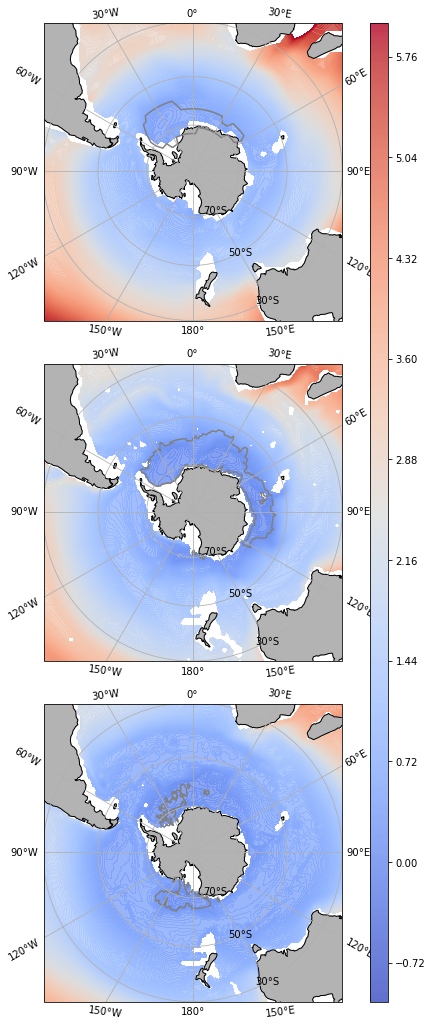

In [7]:
projection = ccrs.SouthPolarStereo()
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(8,18))
# fig = plt.figure()

axgr = AxesGrid(fig, 111, axes_class = axes_class,
                nrows_ncols = (3, 1),
                axes_pad = 0.6,
                cbar_location = 'right',
                cbar_mode = 'single',
                cbar_pad = 0.4,
                cbar_size = '2%',
                label_mode = '')  # note the empty label_mode

my_level = np.arange(-1, 6.02, 0.02)

for i, ax in enumerate(axgr):
    ax.add_feature(cfeature.LAND, zorder=1, color='0.7')
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    
    gl = ax.gridlines(
        xlocs = np.arange(-180,180,30), 
        ylocs = np.arange(-90,90,20),
        draw_labels=True, y_inline=True)
    
    if i == 0:
        diff = sigma0_cm2mc_diff
        conv = conv_cm2mc
    elif i == 1:
        diff = sigma0_esm2g_diff
        conv = conv_esm2g
    else:
        diff = sigma0_cm4_diff
        conv = conv_cm4
    
    diff_new, lon_new = add_cyclic_point(diff.values, coord=diff.lon)

    p = ax.contourf(lon_new, diff.lat, diff_new, transform=ccrs.PlateCarree(), levels = my_level, cmap=plt.cm.coolwarm, alpha = 0.8)
    c = ax.contour(conv.lon, conv.lat, conv.fillna(0).values, levels = 0, colors = 'grey', transform=ccrs.PlateCarree())

axgr.cbar_axes[0].colorbar(p)


# # plt_mld, plt_lon = add_cyclic_point(mld_sep_mean, coord=mld_sep_mean.lon)

# # my_level = np.arange(0,750,5)
# my_level = np.linspace(0.1,6,300)
# im = ax.contourf(sigma0.xt_ocean, sigma0.yt_ocean, sigma0_diff.values, transform=ccrs.PlateCarree(), levels = my_level, cmap=plt.cm.jet)
# cbar = plt.colorbar(im)
# cbar.set_label('m', fontsize=18, rotation=0, horizontalalignment = 'left')
# cbar.ax.tick_params(labelsize=15) 
# plt.title('Average September MLD - year '+ str(start_year) + '-' + str(end_year) + ', ' + model_name, fontsize=18)